# An example pipeline
Using the created classes in the data_utils and utils, we can create fairly efficient pipeline, without running much code.
About the design choices, we chose a pure tensorflow approach using tf datasets, instead of keras imagedatagenerator, since it is quite a bit faster: https://www.tensorflow.org/tutorials/load_data/images   

The following cells will show an example of how to use each function, hopefully also explaining the thought behind the pipeline: avoid repeating alot of routine code, whilst providing flexibility.
   
**Note**: We assume that you have tiled the data into 16x128x128 images, that is located in the data/train folder. See the tiling notebook for more information.
   
**Note2**: Some of this is still work in progress. Ideally, neural networks are created in their own separate files, and then imported and wrapped using the Network class defined in the models folder. Since this is not finished, we will not use it for now in this example. 

In [28]:
%matplotlib inline
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from pprint import pprint
import pandas as pd
from glob import glob
import skimage.io
import sys
from tensorflow.keras.utils import to_categorical
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras import layers as KL
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer
import time

print(tf.__version__)
print(tf.config.experimental.list_physical_devices())

sys.path.insert(0,'..')
from utils.data_utils import PNGTileGenerator, PandasDataLoader
from utils.utils import set_gpu_memory

DATA_DIR = Path('../data/')
set_gpu_memory(device_type='GPU')


2.3.0-dev20200513
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Today:
~~create train/val split~~  
Generalize train/val to KFold training   
create a basic data augmentation   
Image preprocessing   
~~Alter network top with more layers~~   
~~Make a second model that chains two models~~

## Directory processing and declaring constants

In [18]:
# ------------------
# Directories
# ------------------
DATA_DIR = '../data'  # General path to the data dir
IMG_DIR = '../data/train'  # Path to the TILED images
TRAIN_MASKS_DIR = '../data/masks'  # Path to the masks

# ------------------
# Data constants
# ------------------
NFOLDS = 5  # number of folds to use for training/validation (cross validation)
SEED=5  # the seed TODO: REPLACE THIS WITH A FUNCTION THAT SEEDS EVERYTHING WITH SEED
TRAIN_FOLD=0  # select the first fold for training/validation

# ------------------
# Network parameters
# ------------------
# some of these parameters might disappear in a future release
IMG_DIM = (128, 128)  # width and heigth of the image
NUM_CLASSES = 6 
BATCH_SIZE = 16  
NUM_EPOCHS = 15  
NUM_TILES = 16 # the number of tiles that the train folder HAS, it CANNOT be changed freely.
LEARNING_RATE = 1e-4
FOLDED_NUM_TRAIN_IMAGES = train_df.shape[0]
FOLDED_NUM_VALID_IMAGES = valid_df.shape[0]
STEPS_PER_EPOCH = FOLDED_NUM_TRAIN_IMAGES // BATCH_SIZE  # Calculate the steps for keras
VALIDATION_STEPS = FOLDED_NUM_VALID_IMAGES // BATCH_SIZE  # Calculate the same for validation


print('*'*20)
print('Notebook info')
print('Training data : {}'.format(FOLDED_NUM_TRAIN_IMAGES))
print('Validing data : {}'.format(FOLDED_NUM_VALID_IMAGES))
print('Categorical classes : {}'.format(NUM_CLASSES))
print('Training image size : {}'.format(IMG_DIM))
print('Training epochs : {}'.format(NUM_EPOCHS))
print('*'*20)

********************
Notebook info
Training data : 7962
Validing data : 1992
Categorical classes : 6
Training image size : (128, 128)
Training epochs : 15
********************


## Create folds for K fold validation
The class below returns a pandas dataframe with an added 'split' column. The split column contains the fold index, which can in turn be used for cross validation.

Notice also that there are skip_csv and skip_list arguments. The skip_csv arg is a path to a file with image id's of slides that should/could be skipped, since they are faulty due to pen mark. The skip_list argument provides an extra handle to filter out only several reasons. For example, if we only want to filter out faulty images with the reason "no masks", we can do that by adding it to the skip_list.

In [19]:
# an example: loading the skip dataframe and listing the possible reasons
skip_df = pd.read_csv(Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'))
print("possible faulty slide reasons", skip_df['reason'].unique())

fold_df = PandasDataLoader(images_csv_path=Path(DATA_DIR) / Path('train.csv'),
                           skip_csv=Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'), 
                           skip_list=[])

# we create a possible stratification here, the options are by isup grade, or further distilled by isup grade and data provider
# stratified_isup_sample or stratified_isup_dp_sample, we use the former.

fold_df = fold_df.stratified_isup_dp_sample(NFOLDS, SEED)

# we can create training/validation splits from the fold column
train_df = fold_df[fold_df['split'] != TRAIN_FOLD]
valid_df = fold_df[fold_df['split'] == TRAIN_FOLD]

display(train_df)
display(valid_df)

possible faulty slide reasons ['marks' 'No Mask' 'Background only'
 'No cancerous tissue but ISUP Grade > 0' 'tiss' 'blank']
********************
The training dataframe shape before filtering:(10616, 4)
The skip dataframe has shape: (675, 2), with reasons ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
Filtering based on the following columns: ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
number of duplicates in the skip df: (13, 2)
Training dataframe after filtering: (9954, 4)
Number of rows removed by filter: 662
********************


../utils/data_utils.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'] = folds_splits
../utils/data_utils.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'] = folds_splits


,image_id,data_provider,isup_grade,gleason_score,split
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
17,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,3
18,007433133235efc27a39f11df6940829,radboud,0,negative,3
19,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3,4
23,00951a7fad040bf7e90f32e81fc0746f,radboud,1,3+3,4
...,...,...,...,...,...
10613,ffacf52d0c9b3fbf644373c7da4026db,karolinska,2,3+4,4
10617,ffbe854e810d4e4db8fc4acb3ac15333,karolinska,2,3+4,1
10619,ffc0cbbe28a6345a179d6210ef5c579f,karolinska,4,4+4,4
10622,ffcd99c47e57ad2934dc6bbf5edf6675,karolinska,0,0+0,2


,image_id,data_provider,isup_grade,gleason_score,split
20,008069b542b0439ed69b194674051964,radboud,4,4+4,0
22,00928370e2dfeb8a507667ef1d4efcbb,radboud,5,4+5,0
29,00c15b23b30a5ba061358d9641118904,radboud,5,4+5,0
31,00c52cb4db1c7a5811a8f070a910c038,radboud,5,4+5,0
38,00f6ea010b008e7b3635910a13b165a5,radboud,1,3+3,0
...,...,...,...,...,...
10577,feee92608ee1caac1480fa63eb14e739,karolinska,1,3+3,0
10589,ff1896ab1d89b36e8de1922feb21fa8a,karolinska,1,3+3,0
10603,ff596d5292ab979e9ba7291d0743b3fb,karolinska,0,0+0,0
10616,ffb182fa5b636005e21eec384bbf406b,karolinska,0,0+0,0


## Generate dataset
Since we are working with the tf dataset api, we need to pair the actual images with their id's, and convert them to a tf dataset. This is all done for us under the hood in the PNGTileGenerator class
   
**Note:** Tensorflow was at it again during debugging. I wanted to use a tf.vectorized_map function which is more efficient, but this gave low level tensorflow errors. As a result, I had to use map_fn which uses up more resources.

In [23]:
data = PNGTileGenerator(train_df, DATA_DIR / Path('train'), num_tiles=NUM_TILES, batch_size=BATCH_SIZE)
val_data = PNGTileGenerator(valid_df, DATA_DIR / Path('train'), num_tiles=NUM_TILES, batch_size=BATCH_SIZE)

ni


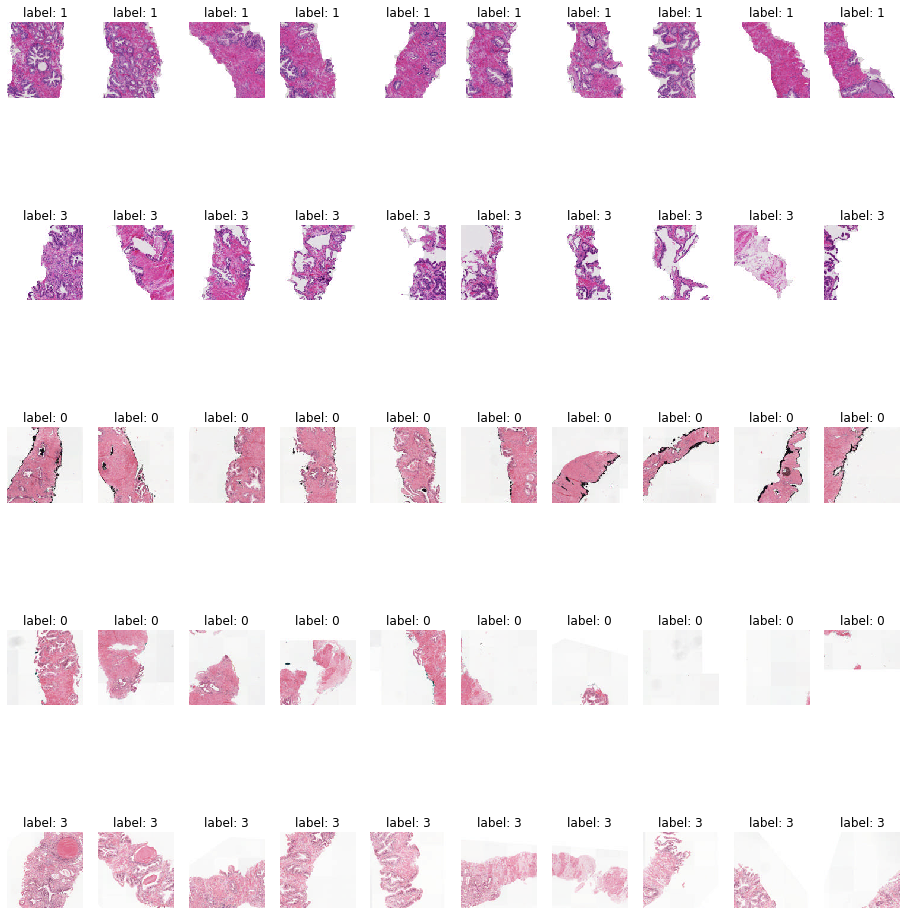

<Figure size 432x288 with 0 Axes>

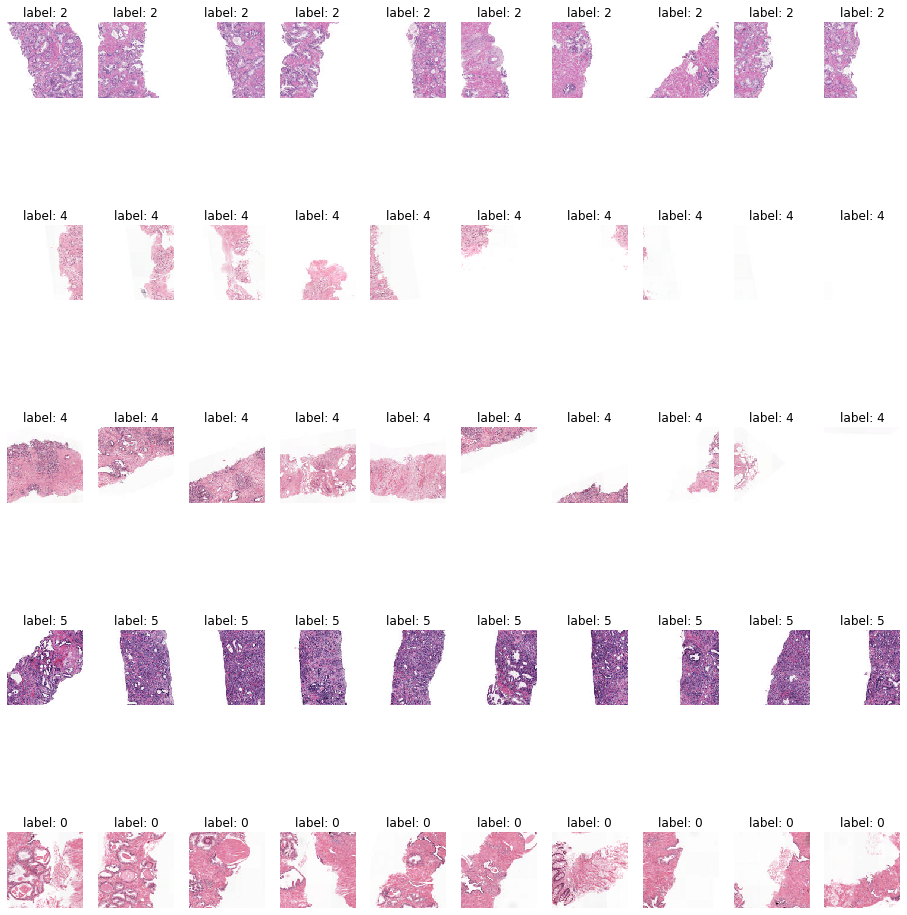

In [29]:
data.display_batch()

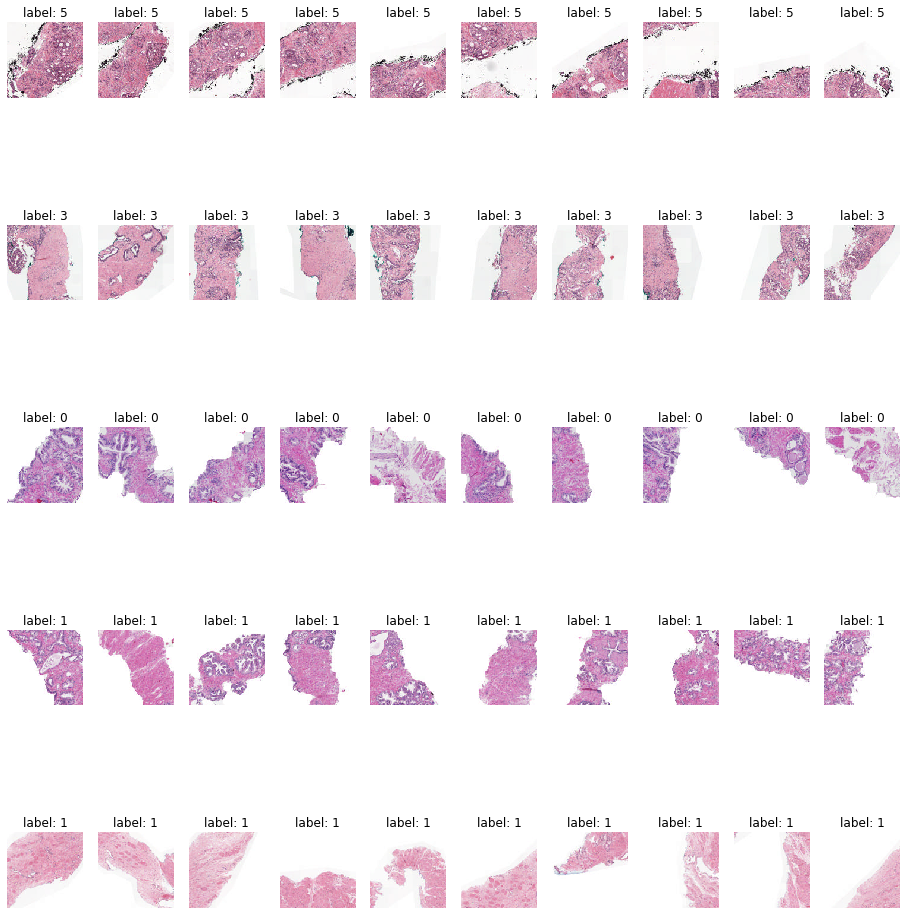

In [30]:
val_data.display_batch()

## Keras method
The intended use of this notebook is to import fully completed models on the fly, and then wrapping them into a Network class in the models folder, but this is not done yet, so the routine is explained here for tiling.   

Since we are using tiling, we have to do some reshaping, including the batch size (at least if we want to use pretrained models). For this, the reshape in the Keras backend module has to be used. The tiles are temporarily transported to the batch dimension, at which point it is reshaped back into the normal shape just before pooling and classification/regression.

In [31]:
def backend_reshape(x, new_shape):
    # casting a shape (bs, N, w/N, H, C) with batch shape None:
    # (-1,N,w/N, H, C), -1 handles the None argument
    return K.reshape(x, new_shape)

In [32]:
inputs = KL.Input(shape=(NUM_TILES,128,128,3), batch_size=None)
x = KL.Lambda(backend_reshape, arguments={'new_shape': (-1, 128, 128, 3)})(inputs)


resnet = tf.keras.applications.ResNet50(include_top=False, input_shape=(128, 128, 3), weights='imagenet')(x)
x = KL.Lambda(backend_reshape, arguments={'new_shape': (-1, NUM_TILES, 4, 4, 2048)})(resnet)
x = KL.Reshape((NUM_TILES * 4, 4, 2048))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.9)(x)
x = tf.keras.layers.Dense(units=512, kernel_initializer='he_normal', activation='relu')(x)
outputs = KL.Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

fake_val = data()

optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', CohenKappa(num_classes=NUM_CLASSES, weightage='quadratic', name='qwk')])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 128, 128, 3)] 0         
_________________________________________________________________
lambda (Lambda)              (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
lambda_1 (Lambda)            (None, 16, 4, 4, 2048)    0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 4, 2048)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)             

In [34]:
# The training loss needs to be < 2 to give decent results
# The training loss needs to be < 1.5 to give stable results
model.fit(data(), steps_per_epoch=STEPS_PER_EPOCH, 
          epochs = NUM_EPOCHS, 
          validation_data=val_data(mode='validation'),
          validation_steps= int(valid_df.shape[0] / BATCH_SIZE))

skipping shuffling operations in validation generator
Epoch 1/15
497/497 [==============================] - 433s 872ms/step - loss: 1.1011 - accuracy: 0.5951 - qwk: 0.7716 - val_loss: 1.9703 - val_accuracy: 0.4360 - val_qwk: 0.2685
Epoch 2/15
497/497 [==============================] - 435s 876ms/step - loss: 0.9740 - accuracy: 0.6315 - qwk: 0.8066 - val_loss: 1.6052 - val_accuracy: 0.5025 - val_qwk: 0.6571
Epoch 3/15
497/497 [==============================] - 433s 871ms/step - loss: 0.8999 - accuracy: 0.6617 - qwk: 0.8299 - val_loss: 1.7243 - val_accuracy: 0.4793 - val_qwk: 0.6199
Epoch 4/15
497/497 [==============================] - 450s 906ms/step - loss: 0.7944 - accuracy: 0.6920 - qwk: 0.8549 - val_loss: 1.7055 - val_accuracy: 0.5207 - val_qwk: 0.6663
Epoch 5/15
497/497 [==============================] - 449s 904ms/step - loss: 0.7517 - accuracy: 0.7165 - qwk: 0.8684 - val_loss: 2.1457 - val_accuracy: 0.3916 - val_qwk: 0.5651
Epoch 6/15
497/497 [==============================] - 45

KeyboardInterrupt: 

In [ ]:
valid_df.shape[0] / BATCH_SIZE

## The stuff below is experimental (do not delete)
The code below tests the tensorflow gradienttape vs keras approach. Some report that the batch layer hack does not work in keras, but the gradienttape approach does work using model chaining. The gradienttape method below does work

## Attempt at chaining models using tensorflow.gradienttape

In [12]:
def build_model():
    stage1_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
    
    input_layer = tf.keras.layers.Input(shape=(4, 4 * NUM_TILES, stage1_model.output_shape[-1]))
    x = tf.keras.layers.GlobalAveragePooling2D()(input_layer)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.9)(x)
    x = tf.keras.layers.Dense(units=512, kernel_initializer='he_normal', activation='relu')(x)
    cls_head = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')(x)
    
    stage2_model = tf.keras.models.Model(inputs=[input_layer], outputs=[cls_head])
    return stage1_model, stage2_model, stage1_model.output_shape[-1]

In [13]:
stage1_model, stage2_model, stage1_channels = build_model()

In [14]:
print(stage1_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = lambda a,b: tf.nn.compute_average_loss(tf.keras.losses.categorical_crossentropy(a,b), global_batch_size=BATCH_SIZE)
train_loss = tf.keras.metrics.Sum()
valid_loss = tf.keras.metrics.Sum()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [16]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as stage1_tape, tf.GradientTape() as stage2_tape:
        images = tf.reshape(images, (-1, 128, 128, 3))
        stage1_output = stage1_model(images, training=True)

        stage1_output = tf.reshape(stage1_output, (-1, NUM_TILES, 4, 4, stage1_channels))
        stage1_output = tf.transpose(stage1_output, (0, 2, 1, 3, 4))
        stage1_output = tf.reshape(stage1_output, (-1, 4, 4*NUM_TILES, stage1_channels))
        stage2_output = stage2_model(stage1_output, training=True)
        
        loss = loss_fn(labels, stage2_output)
        
    stage1_grads = stage1_tape.gradient(loss, stage1_model.trainable_variables)
    stage2_grads = stage2_tape.gradient(loss, stage2_model.trainable_variables)
    
    optimizer.apply_gradients(zip(stage1_grads, stage1_model.trainable_variables))
    optimizer.apply_gradients(zip(stage2_grads, stage2_model.trainable_variables))
    
    train_loss.update_state(loss)
    train_accuracy.update_state(labels, tf.math.argmax(stage2_output, axis=1))
    
def valid_step(images, labels):
    images = tf.reshape(images, (-1, 128, 128, 3))
    stage1_output = stage1_model(images, training=False)

    stage1_output = tf.reshape(stage1_output, (-1, NUM_TILES, 4, 4, stage1_channels))
    stage1_output = tf.transpose(stage1_output, (0, 2, 1, 3,4))
    stage1_output = tf.reshape(stage1_output, (-1, 4, 4*NUM_TILES, stage1_channels))
    stage2_output = stage2_model(stage1_output, training=False)
    
    loss = loss_fn(labels, stage2_output)
    valid_loss.update_state(loss)
    valid_accuracy.update_state(labels, tf.math.argmax(stage2_output, axis=1))
    
    return stage2_output.numpy()

def inference_step(images):
    images = tf.reshape(images, (-1, 128, 128, 3))
    stage1_output = stage1_model(images, training=False)
    stage1_output = tf.reshape(stage1_output, (-1, NUM_TILES, 4, 4, stage1_channels))
    stage1_output = tf.transpose(stage1_output, (0, 2, 1, 3, 4))
    stage1_output = tf.reshape(stage1_output, (-1, 4, 4*NUM_TILES, stage1_channels))
    stage2_output = stage2_model(stage1_output, training=False)
    
    return stage2_output.numpy()    

In [17]:
best_valid_qwk = 0
history = {
    'train_loss' : [],
    'valid_loss' : [],
    'train_accuracy' : [],
    'valid_accuracy' : [],
    'qwk' : []
}

TRAIN_FLAG=True

In [19]:
if TRAIN_FLAG:

    print("Steps per epoch:", STEPS_PER_EPOCH, "Valid steps per epoch:", VALIDATION_STEPS)
    epoch = 0
    for epoch in range(NUM_EPOCHS):
        print("Epoch {} / {}".format(epoch, NUM_EPOCHS))
        start_time = time.time()
        #model training
        
        for step, (images, labels) in  enumerate(data()):
            train_step(images, labels)
            #print('=', end='', flush=True)
            print("step: {} / {}, training loss {:04f}".format(step, 
                                                           STEPS_PER_EPOCH, 
                                                           train_loss.result().numpy() / step), flush=True, end='\r')
        
        #model validation
        predictions = []
        groundtruths = []

        for v_step, (images, labels) in enumerate(val_data(mode='validation')):
            valid_preds = valid_step(images, labels)
            valid_preds = np.argmax(valid_preds, axis=-1)
            groundtruths += list(labels)
            predictions += list(valid_preds)
            if v_step % 10 == 0:
                print('=', end='', flush=True)
        


        groundtruths = np.argmax(np.array(groundtruths), axis=1)
        
        print(predictions[0:100])
        print(groundtruths[0:100])
        qwk = cohen_kappa_score(groundtruths, predictions, labels=None, weights= 'quadratic', sample_weight=None)

        history['train_loss'].append(train_loss.result().numpy() / STEPS_PER_EPOCH)
        history['valid_loss'].append(valid_loss.result().numpy() / VALIDATION_STEPS)
        history['train_accuracy'].append(train_accuracy.result().numpy())
        history['valid_accuracy'].append(valid_accuracy.result().numpy())
        history['qwk'].append(qwk)

        print('\nEPOCH {:d}/{:d}'.format(epoch+1, NUM_EPOCHS))
        print('loss: {:0.4f}'.format(history['train_loss'][-1]),'val_loss: {:0.4f}'.format(history['valid_loss'][-1]))
        print('accuracy : {}'.format(history['train_accuracy'][-1]), 'val_accuracy : {}'.format(history['valid_accuracy'][-1]))
        print('validation qwk : {}'.format(qwk))

        # set up next epoch
        valid_loss.reset_states()
        train_loss.reset_states()
        train_accuracy.reset_states()
        valid_accuracy.reset_states()


        if history['qwk'][-1] > best_valid_qwk:
            print('Validation qwk improve from {} to {}, save model checkpoint'.format(best_valid_qwk, history['qwk'][-1]))
            stage1_model.save('stage1.h5')
            stage2_model.save('stage2.h5')
            best_valid_qwk = history['qwk'][-1]

        print('Spending time : {}...'.format(time.time()-start_time))

Steps per epoch: 525 Valid steps per epoch: 131
Epoch 0 / 15


/vol/tensusers2/sdooper/Anaconda3/envs/panda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


skipping shuffling operations in validation generator
==============[5, 5, 4, 5, 0, 2, 5, 0, 0, 0, 2, 1, 5, 5, 0, 5, 0, 0, 4, 3, 4, 0, 5, 1, 5, 5, 1, 5, 0, 4, 5, 0, 0, 1, 0, 4, 5, 1, 0, 5, 5, 5, 4, 0, 3, 4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 2, 0, 0, 5, 0, 5, 0, 0, 0, 0, 5, 5, 0, 1, 0, 5, 5, 3, 4, 0, 1, 4, 4, 4, 4, 5, 0, 5, 3, 0, 5, 4, 4, 5, 5, 4, 0, 4, 5, 5, 5, 0]
[4 3 2 5 0 2 4 0 3 1 2 2 3 4 0 4 0 1 2 2 4 3 5 5 4 5 1 5 2 5 5 3 0 1 0 5 5
 1 1 5 3 4 4 1 1 3 0 3 1 5 2 5 5 1 0 4 3 1 3 0 2 4 1 5 1 1 1 3 5 3 2 1 0 5
 5 1 3 0 0 2 5 1 3 5 1 5 2 1 3 3 3 5 4 3 1 4 5 4 5 0]

EPOCH 1/15
loss: 1.1697 val_loss: 1.5837
accuracy : 0.1136886328458786 val_accuracy : 0.2009478658437729
validation qwk : 0.6497406201523401
Spending time : 478.2943603992462...
Epoch 1 / 15
skipping shuffling operations in validation generator
==============[4, 5, 0, 5, 0, 3, 4, 0, 4, 0, 2, 3, 4, 4, 0, 3, 0, 2, 4, 2, 4, 4, 3, 4, 4, 5, 1, 4, 4, 4, 4, 1, 4, 0, 0, 4, 4, 1, 1, 5, 4, 4, 4, 0, 2, 4, 0, 4, 0, 4, 1, 0, 4, 0, 0, 4

KeyboardInterrupt: 

## Quick experiences:

1. Using Max pooling instead of just Dense layers slows down training. At this moment idk if it is the network, whether it will be better when run for more epochs, or why this is happening
2. The 'batch hack' seems to work just fine and the model is learning.
3. QWK cohenkappa of tensorflow addons is a stateful metric :)
